In [81]:
import os
import glob
import pathlib
import shutil
from itertools import chain
from functools import partial
from typing import Any, Callable, List, Optional, Tuple, Literal, Union

from PIL import Image

import numpy as np
import torch
from torchvision import datasets, transforms
from torchvision.datasets.utils import extract_archive, iterable_to_str, verify_str_arg
from torchvision.datasets import VisionDataset, Cityscapes


class Cityscapes(datasets.Cityscapes):
    
    def __init__(
        self,
        root: str,
        split: str = "train",
        mode: str = "fine",
        frames_before: int = 0,
        target_type: Union[List[str], str] = "panoptic",
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
    ) -> None:
        VisionDataset.__init__(self, root, transforms, transform, target_transform)
        self.mode = "gtFine" if mode == "fine" else "gtCoarse"
        self.images_dir = os.path.join(self.root, "leftImg8bit", split)
        self.targets_dir = os.path.join(self.root, self.mode, split)
        self.target_type = target_type
        self.split = split
        self.frames_before = frames_before
        self.images = []
        self.targets = []

        verify_str_arg(mode, "mode", ("fine", "coarse"))
        if mode == "fine":
            valid_modes = ("train", "test", "val")
        else:
            valid_modes = ("train", "train_extra", "val")
        msg = "Unknown value '{}' for argument split if mode is '{}'. Valid values are {{{}}}."
        msg = msg.format(split, mode, iterable_to_str(valid_modes))
        verify_str_arg(split, "split", valid_modes, msg)

        if not isinstance(target_type, list):
            self.target_type = [target_type]
        [
            verify_str_arg(value, "target_type", ("panoptic", "instance", "semantic", "polygon", "color"))
            for value in self.target_type
        ]

        if "panoptic" in self.target_type:
            verify_str_arg(mode, "mode", ("fine",), "Panoptic segmentation is only available for fine mode.")
            verify_str_arg(split, "split", ("train", "val"), "Panoptic segmentation is only available for train and val splits.")
            self.mode = "gtFinePanopticParts"
            self.targets_dir = os.path.join(self.root, self.mode, split)

        if not os.path.isdir(self.images_dir) or not os.path.isdir(self.targets_dir):

            if split == "train_extra":
                image_dir_zip = os.path.join(self.root, "leftImg8bit_trainextra.zip")
            else:
                image_dir_zip = os.path.join(self.root, "leftImg8bit_trainvaltest.zip")

            if self.mode == "gtFine":
                target_dir_zip = os.path.join(self.root, f"{self.mode}_trainvaltest.zip")
            elif self.mode == "gtCoarse":
                target_dir_zip = os.path.join(self.root, f"{self.mode}.zip")
            elif self.mode == "gtFinePanopticParts":
                target_dir_zip = os.path.join(self.root, f"{self.mode}_trainval.zip")

            if os.path.isfile(image_dir_zip) and os.path.isfile(target_dir_zip):
                extract_archive(from_path=image_dir_zip, to_path=self.root)
                extract_archive(from_path=target_dir_zip, to_path=self.root)
            else:
                raise RuntimeError(
                    "Dataset not found or incomplete. Please make sure all required folders for the"
                    ' specified "split" and "mode" are inside the "root" directory'
                )

        for city in os.listdir(self.images_dir):
            img_dir = os.path.join(self.images_dir, city)
            target_dir = os.path.join(self.targets_dir, city)
            for file_name in os.listdir(img_dir):
                target_types = []
                for t in self.target_type:
                    target_name = "{}_{}".format(
                        file_name.split("_leftImg8bit")[0], self._get_target_suffix(self.mode, t)
                    )
                    target_types.append(os.path.join(target_dir, target_name))

                self.images.append(os.path.join(img_dir, file_name))
                self.targets.append(target_types)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is a tuple of all target types if target_type is a list with more
            than one item. Otherwise target is a json object if target_type="polygon", else the image segmentation.
        """

        image = Image.open(self.images[index]).convert("RGB")

        targets: Any = []
        for i, t in enumerate(self.target_type):
            if t == "polygon":
                target = self._load_json(self.targets[index][i])
            else:
                target = Image.open(self.targets[index][i])

            targets.append(target)

        target = tuple(targets) if len(targets) > 1 else targets[0]

        if self.transforms is not None:
            augmented = self.transforms(**{
                'image': np.array(image),
                'target': np.array(target),
            })
            image = augmented['image']
            target = augmented['target']

        image_list = [torch.zeros_like(image) for _ in range(self.frames_before)] + [image]
        target_list = [torch.zeros_like(target) for _ in range(self.frames_before)] + [target]

        if not self.frames_before:
            return image, target
        return image_list, target_list

    def _get_target_suffix(self, mode: str, target_type: str) -> str:
        if target_type == "panoptic":
            return f"{mode}.tif"
        elif target_type == "instance":
            return f"{mode}_instanceIds.png"
        elif target_type == "semantic":
            return f"{mode}_labelIds.png"
        elif target_type == "color":
            return f"{mode}_color.png"
        else:
            return f"{mode}_polygons.json"

In [90]:
import torch
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
        A.ToFloat(max_value=255),
        A.augmentations.geometric.LongestMaxSize(max_size=1224, always_apply=True),
        A.RandomCrop(width=1224, height=370),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2()
    ],
    additional_targets={
        'target': 'image'
    }
)

ds = Cityscapes(
    "/mnt/c/dev/repos/pix2seq/data/Cityscapes/",
    mode="fine",
    split="train",
    target_type="panoptic",
    frames_before=5,
    transforms=transform
)



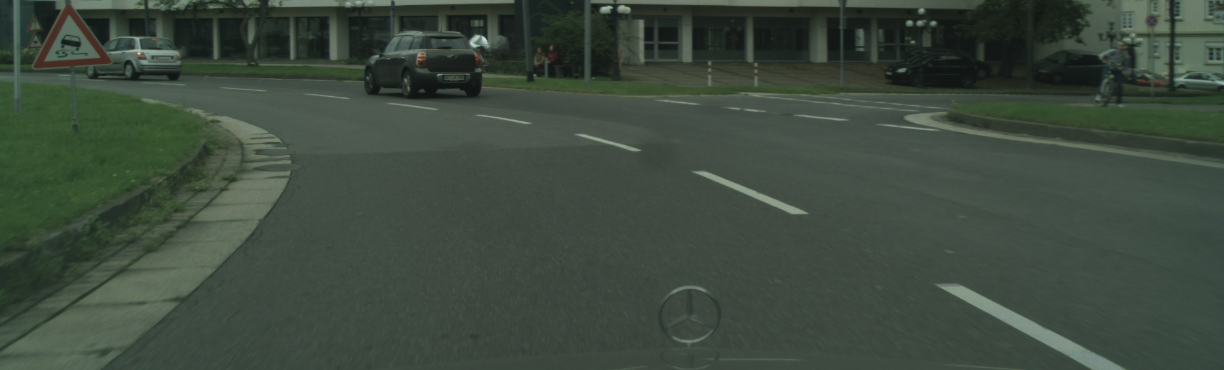

In [103]:
# display(ds[0][0])
# display(transforms.Resize((375, 1242))(ds[0][0]))
display(transforms.ToPILImage()(ds[0][0][5]))

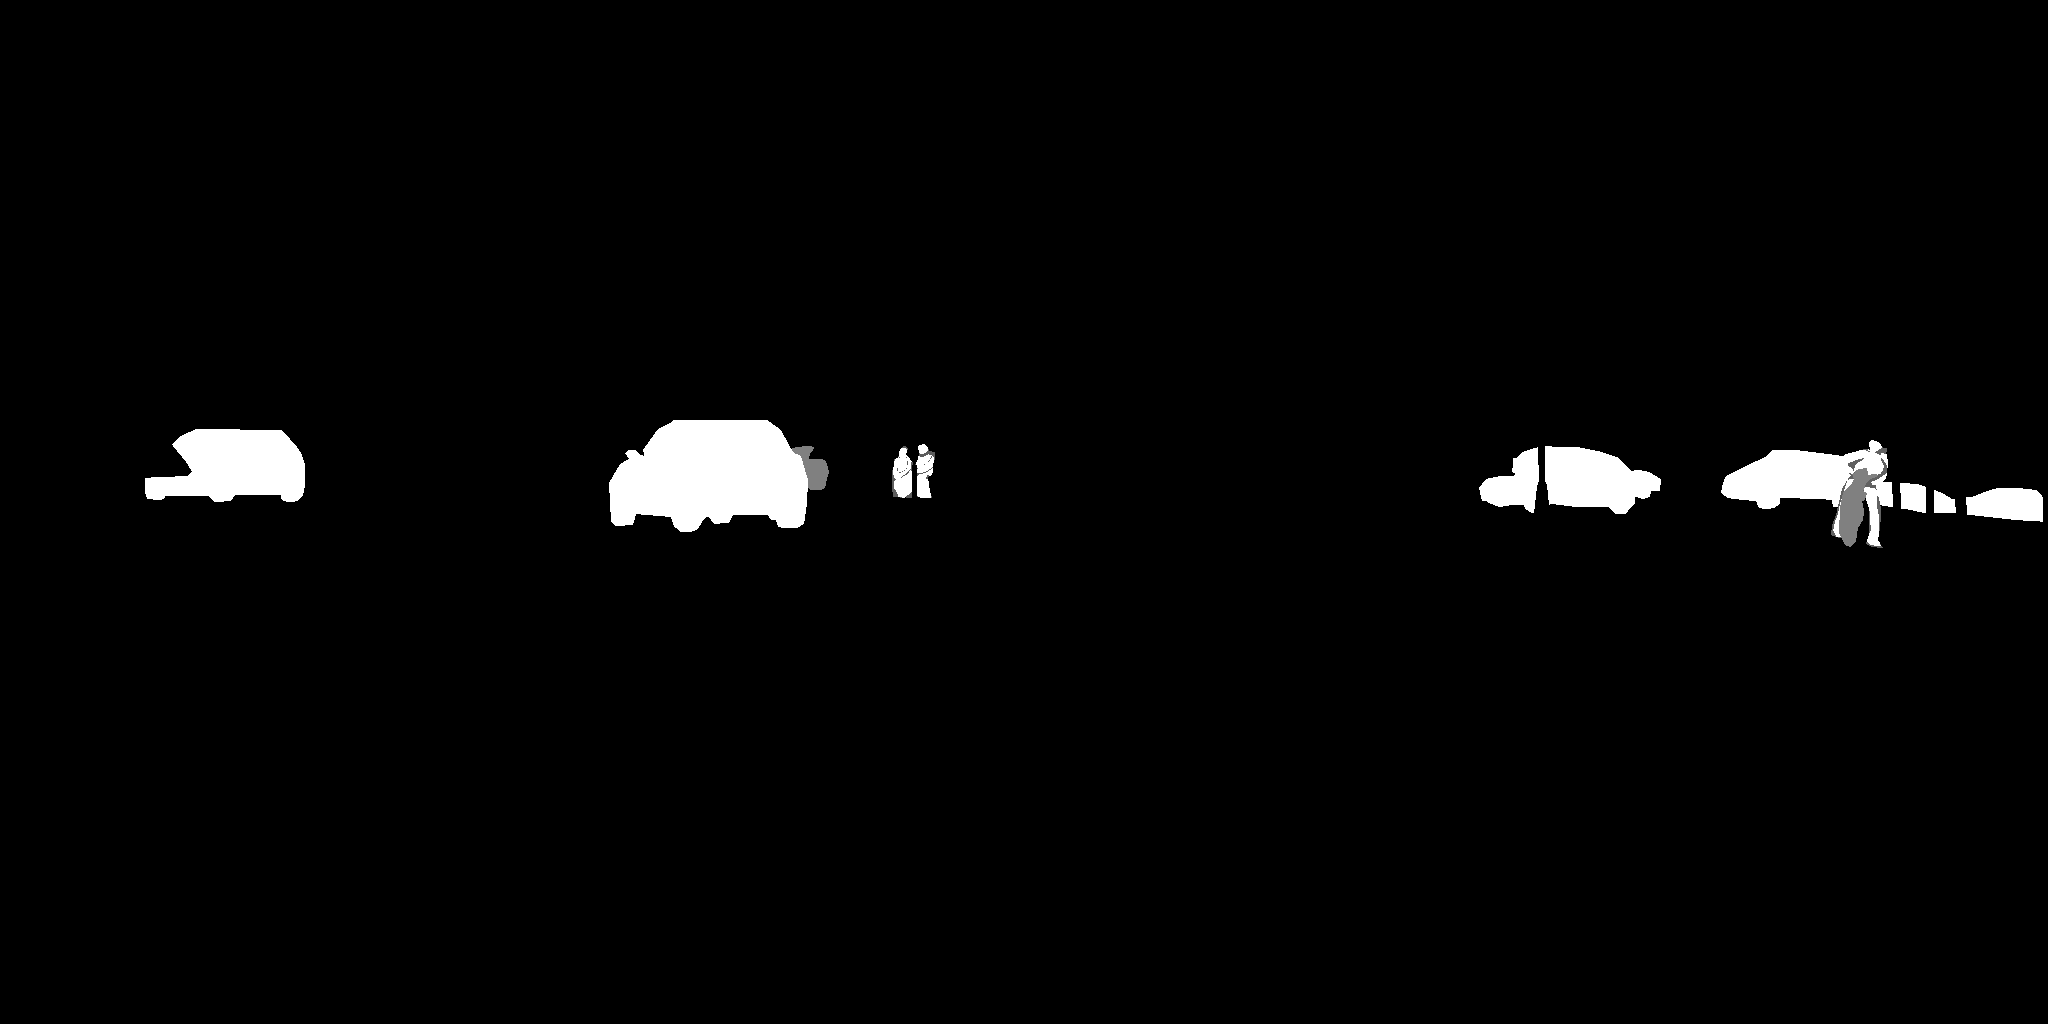

In [38]:
ds[0][1]